In [15]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd
from scipy import stats

In [17]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [19]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# Reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [21]:
# Assign each class to a variable
Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create a session link from Python to the DB
session = Session(engine)

In [23]:
# View a row from the measurement table
measurement_dict = session.query(Measurement).first()
measurement_dict.__dict__
# inspect(engine).get_columns('measurement')
# Measurement.__table__.columns.keys()

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2cc9f5c4fc8>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0}

In [24]:
# View a row from the station table
station_dict = session.query(Station).first()
station_dict.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2cc9f5e1408>,
 'id': 1,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Climate Analysis

In [25]:
# Find the last date in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [26]:
# Find the start date for the query by subtracting a year from the last date
start_date = dt.datetime.strptime('2017-08-23', '%Y-%m-%d') - dt.timedelta(days=366)
start_date

datetime.datetime(2016, 8, 22, 0, 0)

In [51]:
# Retrieve the last 12 months of precipitation data in the database
date_query = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date > start_date).order_by(Measurement.date).all()

In [28]:
# Convert the query results into a dataframe and drop NaN values
prcp_df = pd.DataFrame(date_query).set_index('date').dropna()
prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


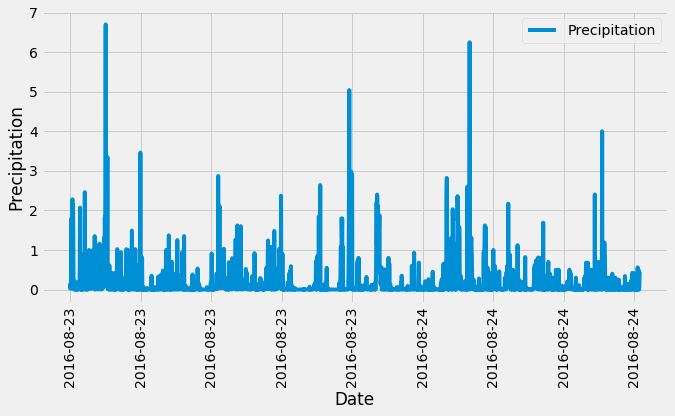

In [29]:
prcp_plot = prcp_df["prcp"].plot(label="Precipitation", figsize=(10,5)).set_xticklabels(prcp_df.index, rotation=90)
plt.ylabel("Precipitation")
plt.xlabel("Date")
plt.legend()
plt.show()

In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [31]:
# Find the number of stations
count = 0

for record in session.query(Station.name):
    print(record)
    count = count + 1

print() 
print(f"There are {count} stations.")

('WAIKIKI 717.2, HI US',)
('KANEOHE 838.1, HI US',)
('KUALOA RANCH HEADQUARTERS 886.9, HI US',)
('PEARL CITY, HI US',)
('UPPER WAHIAWA 874.3, HI US',)
('WAIMANALO EXPERIMENTAL FARM, HI US',)
('WAIHEE 837.5, HI US',)
('HONOLULU OBSERVATORY 702.2, HI US',)
('MANOA LYON ARBO 785.2, HI US',)

There are 9 stations.


In [32]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute('SELECT station, COUNT(date) FROM measurement ' +
                      'GROUP BY station ' + 
                      'ORDER BY COUNT(date) DESC').fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
engine.execute("SELECT station, MAX(tobs), MIN(tobs), COUNT(tobs) FROM measurement " +
                      "WHERE station = 'USC00519281'").fetchall()

[('USC00519281', 85.0, 54.0, 2772)]

In [34]:
# Get the same values using a session.query
temp_query = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.count(
    Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
temp_query

[('USC00519281', 85.0, 54.0, 2772)]

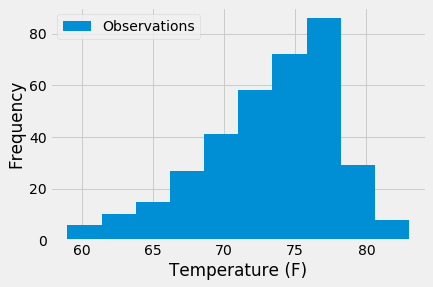

In [35]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hist_query = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(
    Measurement.date > start_date).all()
hist_df = pd.DataFrame(hist_query)
hist_df["tobs"].hist(label="Observations")
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.legend()
plt.title("");

## Bonus Challenge Assignment

### Temperature Analysis I

In [36]:
# Identify the average temperature in June at all stations across all available years in the dataset
# Do the same for December temperature.

# Use the t-test to determine whether the difference in the means, if any, is statistically significant.
# Will you use a paired t-test, or an unpaired t-test? Why?

In [37]:
# Query June temp data
june_data = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(
    Measurement.date.contains('-06-')).order_by(Measurement.date).all()

# June temps as a list
june_temps = [temp[2] for temp in june_data]

# Get average temp in June
june_avg = np.mean(june_temps)

# Query Dec temp data
dec_data = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(
    Measurement.date.contains('-12-')).order_by(Measurement.date).all()

# Dec temps as a list
dec_temps = [temp[2] for temp in dec_data]

# Get average temp in Dec
dec_avg = np.mean(dec_temps)

In [38]:
# Perform a T-test for the means of two independent samples of temperatures.
stats.ttest_ind(june_temps, dec_temps)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

The temperatures in June and December are significantly different.  Even though the means of the temperature groups are very close, there is allot of variation in the values across the groups.  (The p-value is small and the t statistic is large)

### Temperature Analysis II

In [39]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
# print(calc_temps('2012-02-28', '2012-03-05'))

In [40]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-02-10', '2017-02-17'))

[(62.0, 71.75, 80.0)]


In [41]:
# Query June temp data
vacay_data = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(
    (Measurement.date >= '2017-02-10') & (Measurement.date <= '2017-02-17')).order_by(Measurement.date).all()

# Vacay temps as a list
vacay_temps = [temp[2] for temp in vacay_data]
# Get average temp in June
# june_avg = np.mean(june_temps)

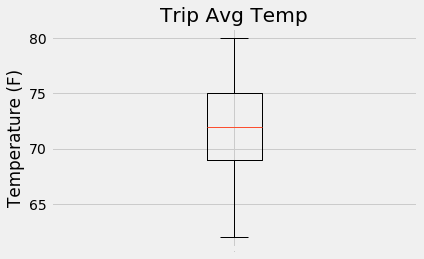

In [42]:
fig, ax = plt.subplots()
ax.boxplot(vacay_temps)
ax.set_title('Trip Avg Temp')
fig.tight_layout()
plt.ylabel("Temperature (F)")
# Get rid of the xtick label
plt.tick_params(axis='x', labelsize=0)
plt.show()

### Daily Rainfall Average

In [43]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [44]:
# Create a list of dates
start_date = dt.date(2017, 2 , 10)
number_of_days = 8

dates = [(start_date + dt.timedelta(days = day)).isoformat() for day in range(number_of_days)]

In [45]:
# Get the month and day for each value from the dates list
date_list = []

for date in dates:
    date_list.append(date[-5:])

In [46]:

temp_dates = []

for date in date_list:
    temp_dates.append(daily_normals(date))

In [47]:
# Convert the list(tuple()) returned by the function into a list for each value
tmin = [item[0] for t in temp_dates for item in t]
tavg = [item[1] for t in temp_dates for item in t]
tmax = [item[2] for t in temp_dates for item in t]

In [48]:
temps_df = pd.DataFrame({'date_list': date_list,
                         'tmin': tmin,
                         'tavg': tavg,
                         'tmax': tmax})
temps_df.set_index('date_list')

,tmin,tavg,tmax
date_list,,,
02-10,56.0,68.416667,76.0
02-11,61.0,69.250000,79.0
02-12,60.0,69.157895,78.0
02-13,58.0,70.362069,80.0
02-14,62.0,70.894737,79.0
02-15,56.0,70.288136,79.0
02-16,59.0,70.482143,76.0
02-17,62.0,70.472727,77.0


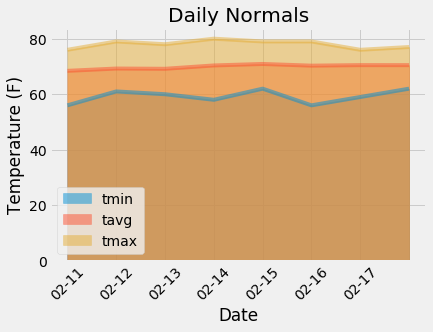

In [49]:
temps_df.plot.area(stacked=False).set_xticklabels(temps_df.date_list, rotation=45)
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.title("Daily Normals");